In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import tqdm
import decoupler as dc
import numpy as np

In [2]:
gtf_path = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley/refs/gencode.v43.annotation.gtf'

In [3]:
gtf_df = pd.read_csv(gtf_path, sep='\t', comment='#',header=None)
gtf_df = gtf_df[gtf_df[2]=='transcript']
gtf_df['transcript_id'] = gtf_df.apply(lambda x: x[8].split(';')[1].split('\"')[1], axis=1)
gtf_df['gene_id'] = gtf_df.apply(lambda x: x[8].split(';')[0].split('\"')[1].split('.')[0], axis=1)
gtf_df['gene_name'] = gtf_df.apply(lambda x: x[8].split(';')[3].split('\"')[1], axis=1)
gene_id_gene_name = dict(zip(gtf_df.gene_id, gtf_df.gene_name))
gene_name_gene_id = dict(zip(gtf_df.gene_name, gtf_df.gene_id))
transcript_id_gene_name = dict(zip(gtf_df.transcript_id, gtf_df.gene_name))
transcript_id_gene_id = dict(zip(gtf_df.transcript_id, gtf_df.gene_id))

In [4]:
pas_dir = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/dif_apa/pas_seq'

In [5]:
def return_class(df):
    if df['log(treatment.p/treatment.d)'] > df['log(Ctrl.p/Ctrl.d)']:
        return 'proximal'
    elif df['log(treatment.p/treatment.d)'] < df['log(Ctrl.p/Ctrl.d)']:
        return 'distal'

def calc_pas_ratio(df):
    return df['log(treatment.p/treatment.d)'] - df['log(Ctrl.p/Ctrl.d)']

In [6]:
sig_PAS_events = {}
sig_PAS = {}
for rbp_table in glob.glob(os.path.join(pas_dir, '*_APA_table.txt')):
    test = pd.read_csv(rbp_table, sep='\t')
    test['treatment.p + 1'] = test['treatment.p'] + 1
    test['treatment.d + 1'] = test['treatment.d'] + 1
    test['Ctrl.p + 1'] = test['Ctrl.p'] + 1
    test['Ctrl.d + 1'] = test['Ctrl.d'] + 1
    test['log(treatment.p/treatment.d)'] = test.apply(lambda x: np.log2(x['treatment.p + 1']/x['treatment.d + 1']), axis=1)
    test['log(Ctrl.p/Ctrl.d)'] = test.apply(lambda x: np.log2(x['Ctrl.p + 1']/x['Ctrl.d + 1']), axis=1)
    test['dif'] = test.apply(calc_pas_ratio, axis=1)
    test['apa_class'] = test.apply(return_class, axis=1)
    test['apa_type'] = test.apply(lambda x: f"{x['TYPE.p']}_{x['TYPE.d']}", axis=1)
    test = test[test['apa_type'].isin(['LastExon_LastExon', 'Intron_LastExon','Intron_Intron'])]
    sig_PAS_events[ rbp_table.split('/')[-1].split('_')[1]] = test
    sig_PAS[ rbp_table.split('/')[-1].split('_')[1]] =test['SYMBOL'].tolist()

In [7]:
salmon_path = '/tscc/nfs/home/pjaganna1/projects/apa_screen_yongsheng/apa_kd_data_graveley_redo/salmon_out'

In [8]:
sequenced_samples = set([i.split('/')[-1].split('-')[0] for i in glob.glob(os.path.join(salmon_path, '*.sf'))])

In [9]:
candidates_list = pd.read_csv('./candidate_list.txt', header=None)[0].tolist()

In [10]:
remove_candidates = ['GTSF1']

In [11]:
final_candidate_list = list((set(candidates_list).intersection(sequenced_samples)) - set(remove_candidates))

In [12]:
final_candidate_list = final_candidate_list + ['NUDT21', 'CPSF6']

In [13]:
len(final_candidate_list)

43

In [14]:
msigdb = dc.get_resource('MSigDB')

/tscc/nfs/home/pjaganna1/anaconda3/envs/decoupler/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='go_biological_process']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]

msigdb.head()

,genesymbol,collection,geneset
33,MAFF,go_biological_process,GOBP_EMBRYO_DEVELOPMENT
44,MAFF,go_biological_process,GOBP_POSITIVE_REGULATION_OF_RNA_METABOLIC_PROCESS
82,MAFF,go_biological_process,GOBP_REGULATION_OF_EPITHELIAL_CELL_DIFFERENTIA...
94,MAFF,go_biological_process,GOBP_EMBRYO_DEVELOPMENT_ENDING_IN_BIRTH_OR_EGG...
108,MAFF,go_biological_process,GOBP_IN_UTERO_EMBRYONIC_DEVELOPMENT


In [16]:
msigdb.loc[:, 'geneset'] = [name.split('GOBP_')[1] for name in msigdb['geneset']]

In [17]:
r_list = []
num_top_terms = []
go_pvals = pd.DataFrame()
for rbp in tqdm.tqdm(final_candidate_list):
    if rbp in sig_PAS:
        r_list.append(rbp)
    
        
        top_genes = pd.DataFrame(sig_PAS[rbp]).copy()
        top_genes = top_genes.rename(columns={0: 'gene_name'})
        top_genes = top_genes.set_index('gene_name')
        top_genes['group'] = 'pas_change'
        
        # Run ora
        enr_pvals = dc.get_ora_df(
            df=top_genes,
            net=msigdb,
            source='geneset',
            target='genesymbol'
        )
        
        total_num_terms = enr_pvals[enr_pvals['FDR p-value']<0.05].shape[0]
        enr_pvals['-log10 FDR p-value'] = -np.log10(enr_pvals['FDR p-value'])
        print(rbp, top_genes.shape[0], enr_pvals[enr_pvals['FDR p-value']<0.05].shape[0])
        keep_term = enr_pvals[enr_pvals['FDR p-value']<0.05].sort_values(by=['-log10 FDR p-value', 'Combined score'],ascending=[False, False])
        num_top_terms.append(enr_pvals[enr_pvals['FDR p-value']<0.05].shape[0])
        keep_term['RBP'] = rbp
        go_pvals = pd.concat([keep_term
                              ,go_pvals])

  2%|▏         | 1/43 [00:00<00:32,  1.29it/s]

TRNAU1AP 884 62


  5%|▍         | 2/43 [00:01<00:29,  1.39it/s]

PCBP1 81 0


  7%|▋         | 3/43 [00:02<00:26,  1.49it/s]

YTHDF1 115 3


  9%|▉         | 4/43 [00:02<00:25,  1.54it/s]

HNRNPH2 198 0


 12%|█▏        | 5/43 [00:03<00:24,  1.57it/s]

RPS19BP1 349 33


 14%|█▍        | 6/43 [00:03<00:24,  1.52it/s]

HNRNPF 1442 219


 16%|█▋        | 7/43 [00:04<00:23,  1.56it/s]

RBM11 79 6


 21%|██        | 9/43 [00:05<00:16,  2.11it/s]

RBM22 33 0


 23%|██▎       | 10/43 [00:05<00:16,  1.95it/s]

TPD52L2 301 4


 26%|██▌       | 11/43 [00:06<00:17,  1.85it/s]

YWHAG 136 5


 28%|██▊       | 12/43 [00:07<00:17,  1.80it/s]

SMNDC1 8 0


 30%|███       | 13/43 [00:07<00:16,  1.77it/s]

EIF4B 39 0


 33%|███▎      | 14/43 [00:08<00:16,  1.73it/s]

MBNL1 91 0


 35%|███▍      | 15/43 [00:08<00:16,  1.67it/s]

RBM5 822 144


 37%|███▋      | 16/43 [00:09<00:16,  1.63it/s]

PPIA 604 61


 40%|███▉      | 17/43 [00:10<00:15,  1.64it/s]

LSM10 27 0


 42%|████▏     | 18/43 [00:10<00:15,  1.62it/s]

LGALS3 410 22


 44%|████▍     | 19/43 [00:11<00:14,  1.63it/s]

RNPS1 25 0


 47%|████▋     | 20/43 [00:11<00:14,  1.63it/s]

RBM14 204 8


 49%|████▉     | 21/43 [00:12<00:14,  1.56it/s]

PCBP3 179 0


 51%|█████     | 22/43 [00:13<00:13,  1.56it/s]

SRP68 511 0


 53%|█████▎    | 23/43 [00:13<00:12,  1.59it/s]

AHNAK 55 0


 56%|█████▌    | 24/43 [00:14<00:12,  1.58it/s]

ZC3HAV1 532 95


 58%|█████▊    | 25/43 [00:15<00:11,  1.61it/s]

PRPF4 52 0


 63%|██████▎   | 27/43 [00:15<00:07,  2.08it/s]

RBM4 288 70


 65%|██████▌   | 28/43 [00:16<00:07,  1.96it/s]

RBM42 54 0


 67%|██████▋   | 29/43 [00:16<00:07,  1.88it/s]

WDR6 19 0


 72%|███████▏  | 31/43 [00:17<00:05,  2.30it/s]

PPP1CA 81 11


 74%|███████▍  | 32/43 [00:18<00:05,  2.11it/s]

RBM10 24 0


 77%|███████▋  | 33/43 [00:18<00:05,  1.91it/s]

MBNL2 1023 142


 79%|███████▉  | 34/43 [00:19<00:04,  1.83it/s]

ZMAT3 97 0


 81%|████████▏ | 35/43 [00:20<00:04,  1.79it/s]

STAU2 23 0


 84%|████████▎ | 36/43 [00:20<00:04,  1.74it/s]

GRB2 208 43


 86%|████████▌ | 37/43 [00:21<00:03,  1.72it/s]

DZIP3 24 13


 88%|████████▊ | 38/43 [00:21<00:02,  1.70it/s]

LSM1 82 0


 91%|█████████ | 39/43 [00:22<00:02,  1.69it/s]

SCAF8 120 0


 93%|█████████▎| 40/43 [00:23<00:01,  1.61it/s]

CNOT2 156 0


 95%|█████████▌| 41/43 [00:23<00:01,  1.55it/s]

PARN 21 4


 98%|█████████▊| 42/43 [00:24<00:00,  1.42it/s]

NUDT21 2366 366


100%|██████████| 43/43 [00:25<00:00,  1.69it/s]

CPSF6 698 131


In [18]:
go_pvals.head()

,Term,Set size,Overlap ratio,p-value,FDR p-value,Odds ratio,Combined score,Features,-log10 FDR p-value,RBP
1120,INTRACELLULAR_TRANSPORT,1574,0.073062,1.640384e-14,6.983113e-11,2.316548,73.530156,ACAP2;AGFG1;AKIRIN2;AP1G1;AP3B1;ARIH2;ARL8B;AR...,10.155951,CPSF6
2783,PROTEIN_LOCALIZATION_TO_ORGANELLE,906,0.083885,1.118797e-12,2.381359e-09,2.588586,71.234689,ADAM10;AKIRIN2;ANKRD13C;AP3B1;ARIH2;ATF2;ATG13...,8.623175,CPSF6
790,ESTABLISHMENT_OF_PROTEIN_LOCALIZATION,1655,0.067069,1.284071e-11,1.822097e-08,2.103136,52.743288,ACSL3;AKIRIN2;AP1G1;AP3B1;ARFGEF2;ARIH2;ARL6IP...,7.739429,CPSF6
1116,INTRACELLULAR_PROTEIN_TRANSPORT,863,0.081112,4.335016e-11,4.613541e-08,2.486032,59.320974,AKIRIN2;AP1G1;AP3B1;ARIH2;ATF2;ATG13;BAG4;BARD...,7.335966,CPSF6
795,ESTABLISHMENT_OF_PROTEIN_LOCALIZATION_TO_ORGAN...,442,0.097285,1.451386e-09,1.235710e-06,2.933181,59.692419,AKIRIN2;AP3B1;ARIH2;ATF2;ATG13;BAG4;BNIP3L;ECT...,5.908083,CPSF6


/tscc/nfs/home/pjaganna1/anaconda3/envs/decoupler/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/tscc/nfs/home/pjaganna1/anaconda3/envs/decoupler/lib/python3.11/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


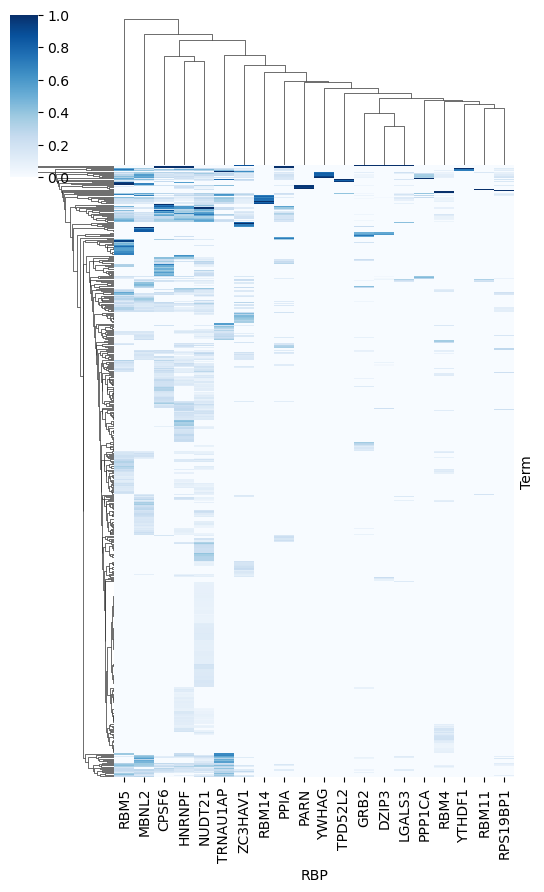

In [20]:
to_plot = go_pvals.copy()

sns.clustermap(to_plot.pivot(index='RBP', columns='Term', values='Combined score').fillna(0).T, 
               standard_scale=1, 
               figsize=(5.5,9), 
               cmap='Blues',
              yticklabels=False)
plt.savefig('./figures/pas_target_GO_all_terms_heatmap.png')
plt.savefig('./figures/pas_target_GO_all_terms_heatmap.jpg')
plt.savefig('./figures/pas_target_GO_all_terms_heatmap.svg')